In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
from array import array
import collections

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = inputdir+'xsec_momentum_G4/' 
output_filedir = outputdir
input_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_weighted/'
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')

Welcome to JupyROOT 6.10/08


In [2]:
#!jupyter nbconvert --to script numuCCana_xsec_flux_momentum.ipynb

In [3]:
# initialte ROOT default canvas
ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gStyle.SetOptTitle(0)
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# G4 variation, combine, systematic

In [4]:
# Load input files
outputdir_png, outputdir_root,outputdir_pdf = NuCC.prepareOutput2(outputdir)

pot_data =    7.644e+18

try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"G4_systematic_combine.root","RECREATE");


In [5]:
##### flux and number of tragets parameters###
flux = 1.16859e11/1.592e20 # flux per POT per cm2
print flux
flux = 7.3789785277e-10
print flux
roh_data = 1.3836 #data denisity g/cm3
roh_MC = 1.3954 # MC denisity g/cm3
mol = 39.95 # g for argon
N_A = 6.022140857e23 # molec/mol avogadro zahl
N_nucleons = 40.0
V_fid = ((254.8-10)-(-1.55+10))*((117.47-10)-(-115.53+10))*((1036.9-50)-(-0.1+10))
print 'Fiducial Volume: ', V_fid
##############################################

beam_flux = flux * pot_data
print 'Beam flux = {:.5e}'.format(beam_flux),' /cm2'
N_tot = roh_data*N_A*N_nucleons*V_fid/mol
print 'Number of target nuclei= {:.5e}'.format(N_tot),' /cm3'

7.34038944724e-10
7.3789785277e-10
Fiducial Volume:  49184671.35
Beam flux = 5.64049e+09  /cm2
Number of target nuclei= 4.10331e+31  /cm3


In [6]:
weight_list_flux = ['reinteractions_piminus_Geant4', 'reinteractions_piplus_Geant4', 'reinteractions_proton_Geant4']
num_para = len(weight_list_flux)
print 'Nuber of parameters: ',num_para

Nuber of parameters:  3


In [7]:
weight_name = 'EventWeight*TunedCentralValue_Genie'
num_universes = 10
eff_uni = np.zeros((num_para,num_universes))
mom_bins = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
binnum = len(mom_bins) - 1

In [8]:
def draw_adding():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/30.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

In [9]:
path = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_35/weighted/'
f = ROOT.TFile.Open(path+"xsec_momentum_G4/root_output/G4_systematic.root", 'read')

In [10]:

h_ext_mom = f.Get("h_ext_mom")
h_data_mom = f.Get("h_data_mom")
h_dirt_mom = f.Get("h_dirt_mom")

bkg_ext = h_ext_mom.Integral(0,binnum+1)
num_data = h_data_mom.Integral(0,binnum+1)
bkg_dirt = h_dirt_mom.Integral(0,binnum+1)
print 'Data: ', num_data,' Ext: ', bkg_ext,' Dirt: ',bkg_dirt

Data:  1348.0  Ext:  142.179031156  Dirt:  32.1298251934


In [11]:

h_1d = []
h_1d_true = []

for para in range(num_para):
    h_1d.append([])
    h_1d_true.append([])
    for uni in range(num_universes):
        h_1d[para].append(f.Get('h_1d['+str(para)+']['+str(uni)+']'))
        h_1d_true[para].append( f.Get('h_1d_true['+str(para)+']['+str(uni)+']' ))

for para in range(num_para): 
    print 'Get efficiency of Parameter: ', weight_list_flux[para]
    for uni in range(num_universes):
        #globale.overlay_out.Draw(variable+'>>h_1d['+str(para)+']['+str(uni)+']',weight_name+'*'+weight_list_flux[para]+'['+str(uni)+']*('+cut+'&& numu_signal)')
        #globale.overlay_out.Draw(variable+'>>h_1d_true['+str(para)+']['+str(uni)+']',weight_name+'*'+weight_list_flux[para]+'['+str(uni)+']*(numu_true)')
        num_signal = h_1d[para][uni].Integral(0,binnum+1)
        num_true = h_1d_true[para][uni].Integral(0,binnum+1)
        eff_uni[para][uni] = num_signal/(num_true+0.0001)
        #h_1d[para][uni].Write('h_1d['+str(para)+']['+str(uni)+']')
        #h_1d_true[para][uni].Write('h_1d_true['+str(para)+']['+str(uni)+']')
        print 'Parameter: ', weight_list_flux[para], ' Universe: ', uni, ' signal: {0:0.0f}'.format(num_signal),' True: {0:0.0f}'.format(num_true),' Eff: {0:0.4f}'.format(eff_uni[para][uni])
# save the efficiencies
#np.save(output_filedir+'xsec_flux_tot_efficiencies',eff_uni)
print 'Total std of efficiency (all parameters, all universes)',eff_uni.std()

Get efficiency of Parameter:  reinteractions_piminus_Geant4
Parameter:  reinteractions_piminus_Geant4  Universe:  0  signal: 161415  True: 307027  Eff: 0.5257
Parameter:  reinteractions_piminus_Geant4  Universe:  1  signal: 161447  True: 307070  Eff: 0.5258
Parameter:  reinteractions_piminus_Geant4  Universe:  2  signal: 161516  True: 307161  Eff: 0.5258
Parameter:  reinteractions_piminus_Geant4  Universe:  3  signal: 161394  True: 307014  Eff: 0.5257
Parameter:  reinteractions_piminus_Geant4  Universe:  4  signal: 161409  True: 307026  Eff: 0.5257
Parameter:  reinteractions_piminus_Geant4  Universe:  5  signal: 161458  True: 307093  Eff: 0.5258
Parameter:  reinteractions_piminus_Geant4  Universe:  6  signal: 161478  True: 307118  Eff: 0.5258
Parameter:  reinteractions_piminus_Geant4  Universe:  7  signal: 161483  True: 307117  Eff: 0.5258
Parameter:  reinteractions_piminus_Geant4  Universe:  8  signal: 161434  True: 307059  Eff: 0.5257
Parameter:  reinteractions_piminus_Geant4  Univer

In [12]:
bkg_uni = np.zeros((num_para,num_universes))
h_1d_bkg = []
for para in range(num_para):
    h_1d_bkg.append([])
    for uni in range(num_universes):
        #print 'At universe: ',uni
        h_1d_bkg[para].append( f.Get('h_1d_bkg['+str(para)+']['+str(uni)+']') )

for para in range(num_para):
    print 'Get background of Parameter: ', weight_list_flux[para]
    for uni in range(num_universes):
        #globale.overlay_out.Draw(variable+'>>h_1d_bkg['+str(para)+']['+str(uni)+']',weight_name+'*'+weight_list_flux[para]+'['+str(uni)+']*('+cut+'&& !numu_signal)')
        #h_1d_bkg[para][uni].Scale(globale.scale[globale.overlay])
        bkg_uni[para][uni] = h_1d_bkg[para][uni].Integral(0,binnum+1)
        #h_1d_bkg[para][uni].Write('h_1d_bkg['+str(para)+']['+str(uni)+']')
        #print 'Parameter: ', weight_list_flux[para], ' Universe: ', uni, ' Overlay: ',bkg_uni[para][uni]


Get background of Parameter:  reinteractions_piminus_Geant4
Get background of Parameter:  reinteractions_piplus_Geant4
Get background of Parameter:  reinteractions_proton_Geant4


In [13]:
xsec_uni = np.zeros((num_para,num_universes)) 
xsec_diff = np.zeros((num_para,num_universes))
sigma_tot = np.zeros((num_para))
sigma_all_para = 0.0

xsec_CV = 8.0108768993e-39 

for para in range(num_para):
    for uni in range(num_universes):
        xsec_uni[para][uni] = (num_data - bkg_ext - bkg_dirt - bkg_uni[para][uni])/(eff_uni[para][uni]*beam_flux*N_tot)
        xsec_diff[para][uni] = xsec_uni[para][uni] - xsec_CV
        #print 'Total flux integrated xsec: ',xsec_uni[para][uni],' change: ', (xsec_uni[para][uni] - xsec_CV)/xsec_CV*100
        sigma_tot[para] = sigma_tot[para]+xsec_diff[para][uni]*xsec_diff[para][uni]
    sigma_tot[para] = sigma_tot[para]/num_universes
    print 'Parameter: %25s'% weight_list_flux[para], ' deviatons: {0:0.5e}%'.format(math.sqrt(sigma_tot[para])),' in percent: {0:0.5f}%'.format(math.sqrt(sigma_tot[para])*100.0/xsec_CV,'%')
    sigma_all_para = sigma_all_para+sigma_tot[para]
    
print 'Total all parameters xsec CV: ',xsec_CV,' deviatons: ',math.sqrt(sigma_all_para),' in percent: ',math.sqrt(sigma_all_para)*100.0/xsec_CV,'%'


Parameter: reinteractions_piminus_Geant4  deviatons: 2.58338e-42%  in percent: 0.03225%
Parameter: reinteractions_piplus_Geant4  deviatons: 6.33044e-42%  in percent: 0.07902%
Parameter: reinteractions_proton_Geant4  deviatons: 1.34422e-41%  in percent: 0.16780%
Total all parameters xsec CV:  8.0108768993e-39  deviatons:  1.50811747035e-41  in percent:  0.188258724894 %


In [14]:
# check standard deviations on the true efficiency
np.std(eff_uni)
#Since the efficiency does not change very much per universe the nominal efficiency e_tilde is used
# in order not to calculated the whole detector smearing again
eff_tilde = np.load('/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_filesV4/'+'eff_tilde_momentum_xsec_CV.npy')
print input_filedir
print eff_tilde

/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_weighted/
[0.21008295 0.3497971  0.46116033 0.56207302 0.6465205  0.66773328
 0.61680932]


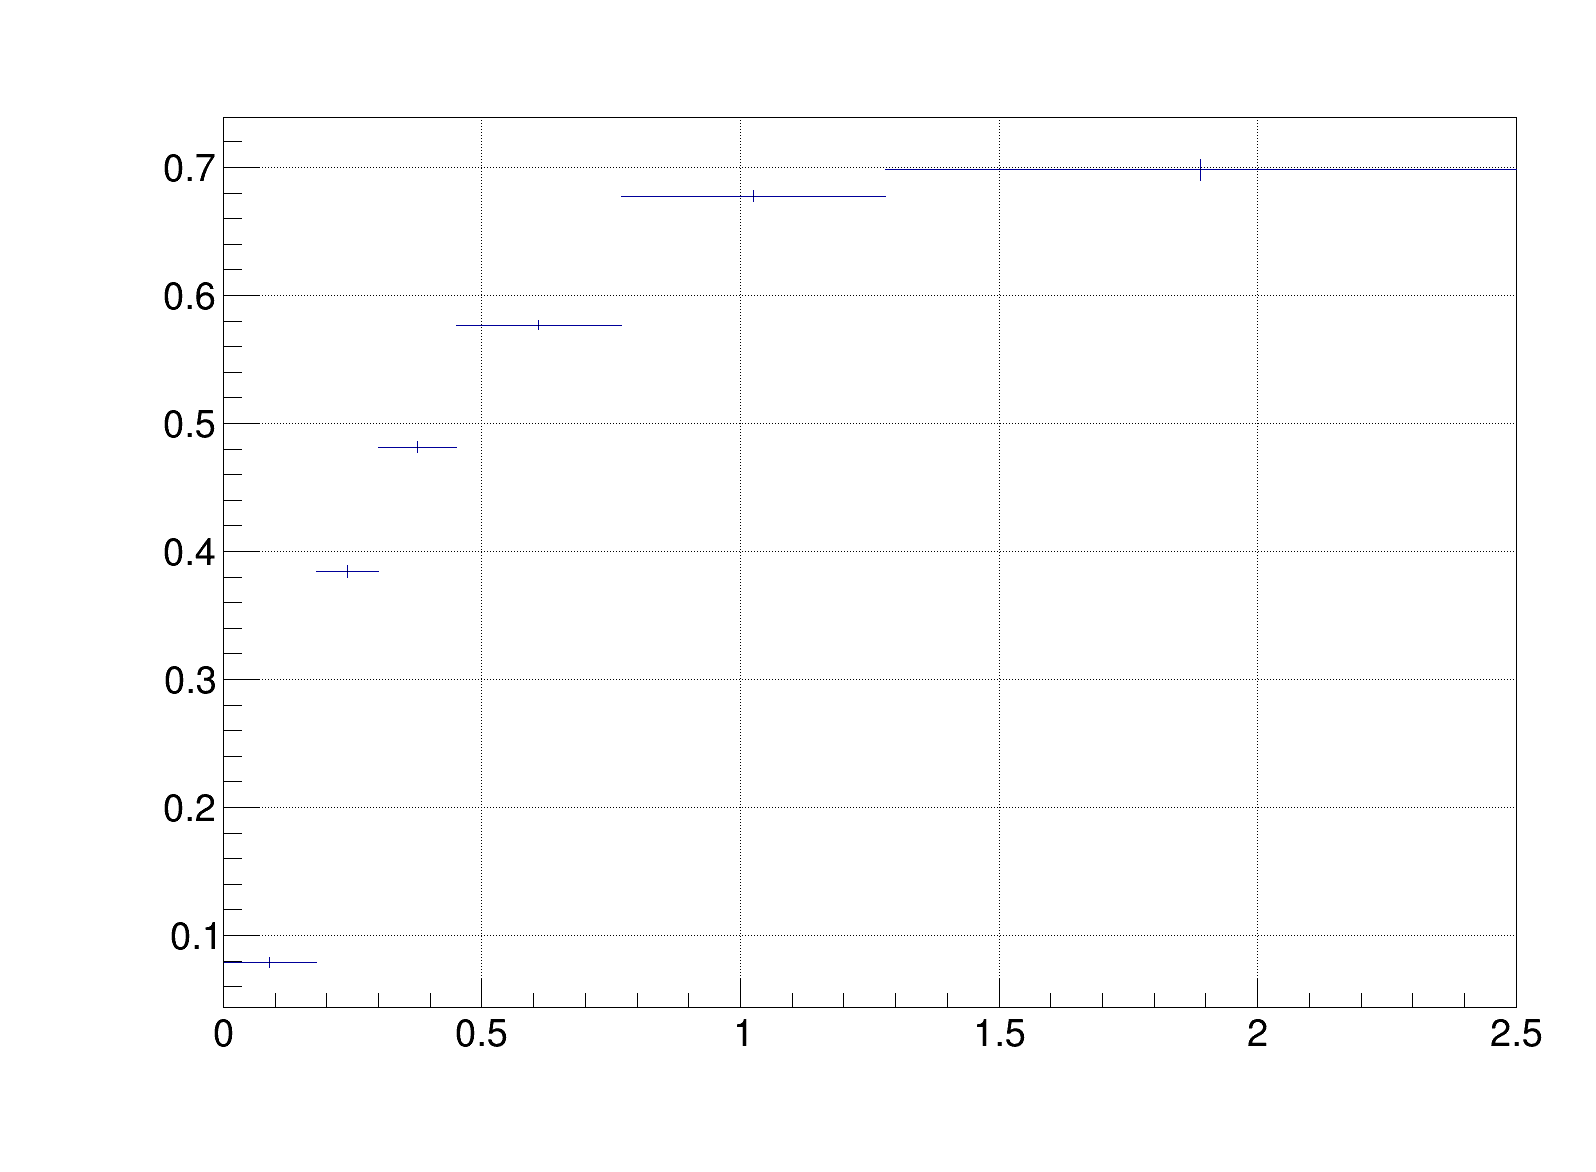

In [15]:

h_eff_true = []
h_eff_tilde = []
for para in range(num_para):
    h_eff_tilde.append([])
    h_eff_true.append([])
    for uni in range(num_universes):
        #print 'At universe: ',uni
        h_eff_tilde[para].append( f.Get('h_eff_tilde['+str(para)+']['+str(uni)+']') ) 
        h_eff_true[para].append( f.Get('h_eff_true['+str(para)+']['+str(uni)+']') ) 
h_eff_true[0][0].Draw()
c1.Draw()

In [16]:

for para in range(num_para):
    xsec_uni_bin = np.zeros((num_universes,binnum))
    #print para
    for uni in range(num_universes):
        #print uni
        for i in range(binnum):
            xsec_uni_bin[uni][i] = h_data_mom.GetBinContent(i+1) - h_ext_mom.GetBinContent(i+1) - h_dirt_mom.GetBinContent(i+1) - h_1d_bkg[para][uni].GetBinContent(i+1)
            xsec_uni_bin[uni][i] = xsec_uni_bin[uni][i]/(eff_tilde[i] * N_tot * beam_flux * h_data_mom.GetBinWidth(i+1))
    #print xsec_uni_bin
        #if xsec_uni_bin[uni][i] == 0:
        #    print 

    xsec_std_bin = np.std(xsec_uni_bin,axis=0)
    #print xsec_uni_bin
    np.save(output_filedir+'xsec_'+weight_list_flux[para]+'_momentum',xsec_std_bin)

In [17]:
# save the total difference in percent
np.save(output_filedir+'xsec_percent_diff_momentum',xsec_std_bin)

In [18]:
# initialte ROOT default canvas
#ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gStyle.SetOptTitle(0)
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [19]:
# load CV values
path = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_filesV4/'
f_cv = ROOT.TFile.Open(path+"xsec_momentum_wighted.root", 'read')
h_cv = f_cv.Get("h_xsec_data")
h_cv.Scale(1e-38)


In [20]:
h_1d_xsec = []
print num_universes
for para in range(num_para):
    h_1d_xsec.append([])
    for uni in range(num_universes):
        #print 'At universe: ',uni
        h_1d_xsec[para].append( ROOT.TH1F('h_1d_xsec['+str(para)+']['+str(uni)+']',"xsec momentum",binnum,array('f',mom_bins)) )

legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
#legend = ROOT.TLegend(0.15,0.65,0.3,0.9) # LEGEND LEFT

for para in range(num_para):#num_para
    for uni in range(num_universes):    #num_universes 
        #xsec_uni_bin[uni][i] = h_data_mom.GetBinContent(i+1) - h_ext_mom.GetBinContent(i+1) - h_dirt_mom.GetBinContent(i+1) - h_1d_bkg[para][uni].GetBinContent(i+1)
        #xsec_uni_bin[uni][i] = xsec_uni_bin[uni][i]/(eff_tilde[i] * N_tot * beam_flux * h_data_mom.GetBinWidth(i+1))
        h_1d_xsec[para][uni] = h_data_mom.Clone()
        h_1d_xsec[para][uni].Add(h_ext_mom,-1)
        h_1d_xsec[para][uni].Add(h_dirt_mom,-1)
        h_1d_xsec[para][uni].Add(h_1d_bkg[para][uni],-1)
        h_1d_xsec[para][uni].Scale(1.0/(N_tot * beam_flux ))
        h_1d_xsec[para][uni].SetLineColor(para+2)
        h_1d_xsec[para][uni].SetLineWidth(3)
        h_1d_xsec[para][uni].Divide(h_eff_tilde[para][uni])
        for i in range(1,binnum+1):
            value = h_1d_xsec[para][uni].GetBinContent(i)
            width = h_1d_xsec[para][uni].GetBinWidth(i)
            h_1d_xsec[para][uni].SetBinContent(i,value/(width))
            h_1d_xsec[para][uni].SetBinError(i,h_1d_xsec[para][uni].GetBinError(i)/(width))
            #if i == 2:
            #print value/width, value, width
    legend.AddEntry(h_1d_xsec[para][uni],weight_list_flux[para],"f")
        

10


In [21]:
for i in range(1,binnum+1):
    print h_1d_xsec[para][uni].GetBinContent(i),h_1d_xsec[para][uni].GetBinError(i)

5.78074852891e-40 5.52686671717e-40
9.14186098649e-39 1.40842642398e-39
1.24752571617e-38 1.13089817068e-39
9.91111779146e-39 5.48034237666e-40
3.04053740789e-39 2.16247985254e-40
1.76719150634e-40 3.57912746034e-41


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/png/h_1d_xsec_G4.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/root/h_1d_xsec_G4.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/pdf/h_1d_xsec_G4.pdf has been created


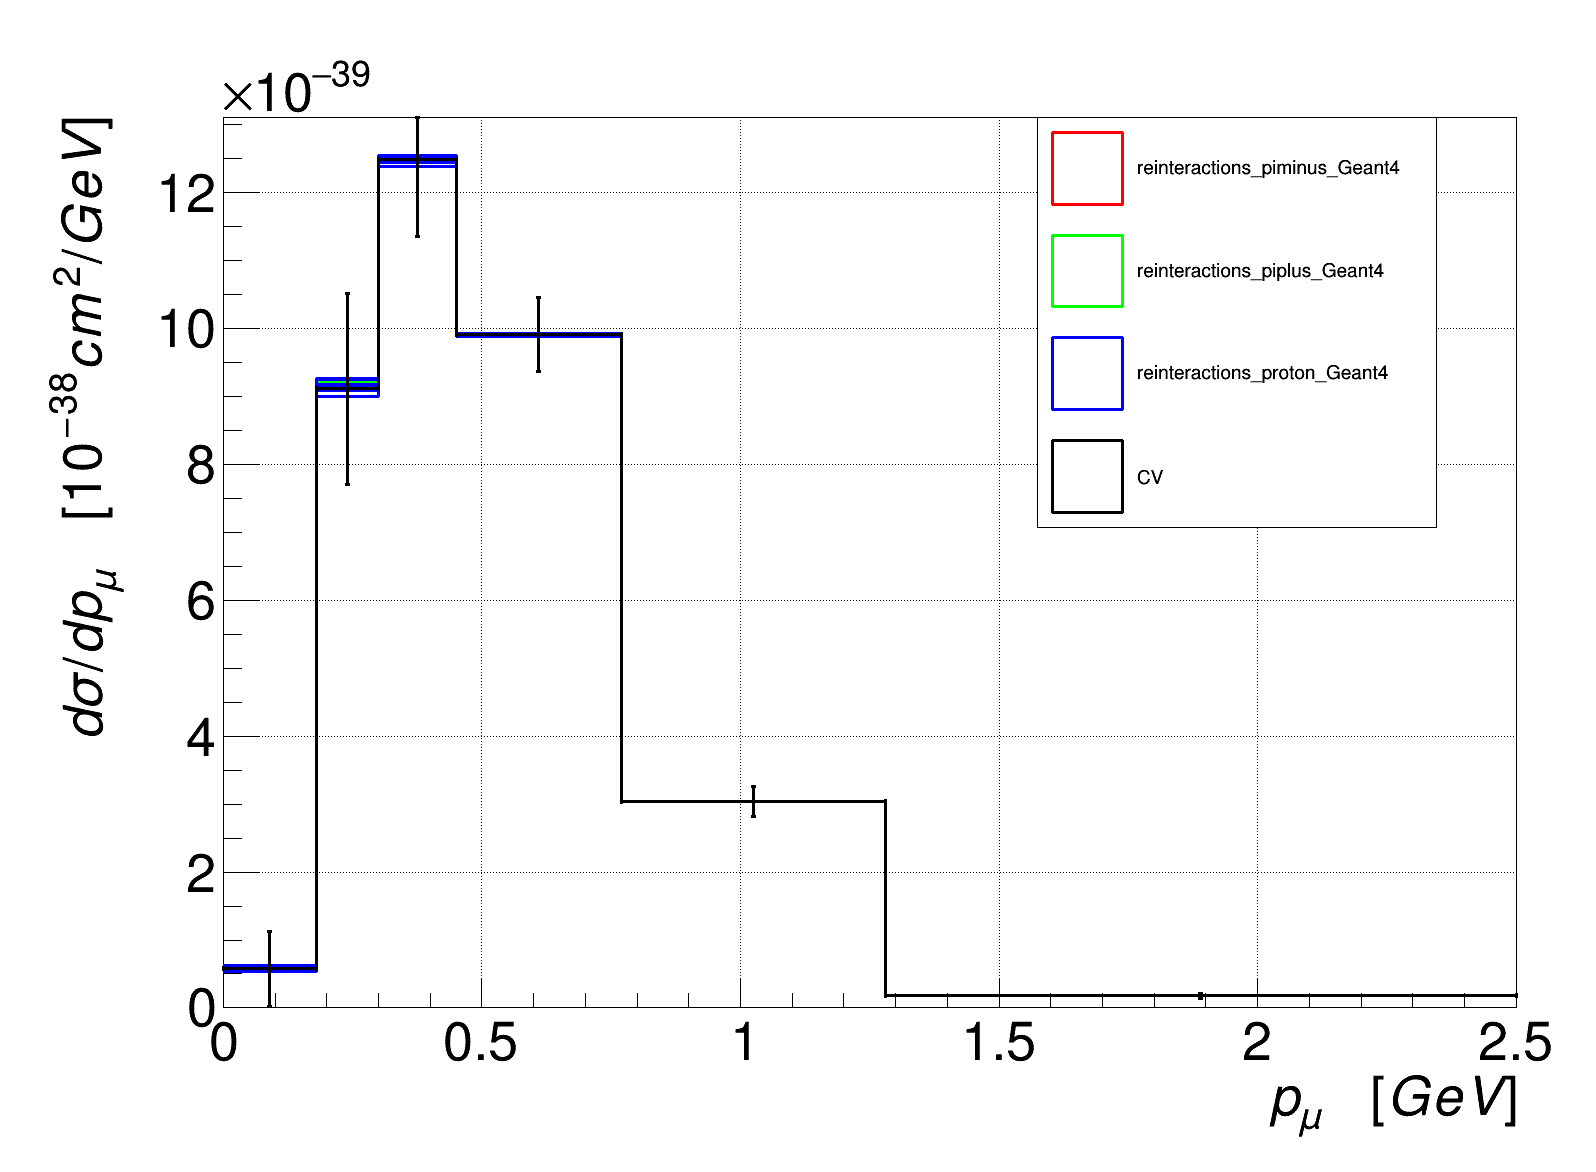

In [22]:
legend.AddEntry(h_cv,'CV',"f")
h_cv.SetLineWidth(3)
h_cv.Draw('HIST')
for para in range(num_para):
    for uni in range(num_universes):        
        h_1d_xsec[para][uni].Draw('HIST same ')
        #h_1d_xsec[para][uni]..SetMaximum(1.6)
        #print h_1d_xsec[para][uni].GetBinContent(3),' - ', h_1d_bkg[para][uni].GetBinContent(3)
legend.Draw()
h_cv.Draw('HIST E1 same')
c1.Draw()
c1.SaveAs(outputdir_png + "h_1d_xsec_G4.png")
c1.SaveAs(outputdir_root + "h_1d_xsec_G4.root")
c1.SaveAs(outputdir_pdf + "h_1d_xsec_G4.pdf")


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/png/h_1d_bkgd_G4.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/root/h_1d_bkgd_G4.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/pdf/h_1d_bkgd_G4.pdf has been created


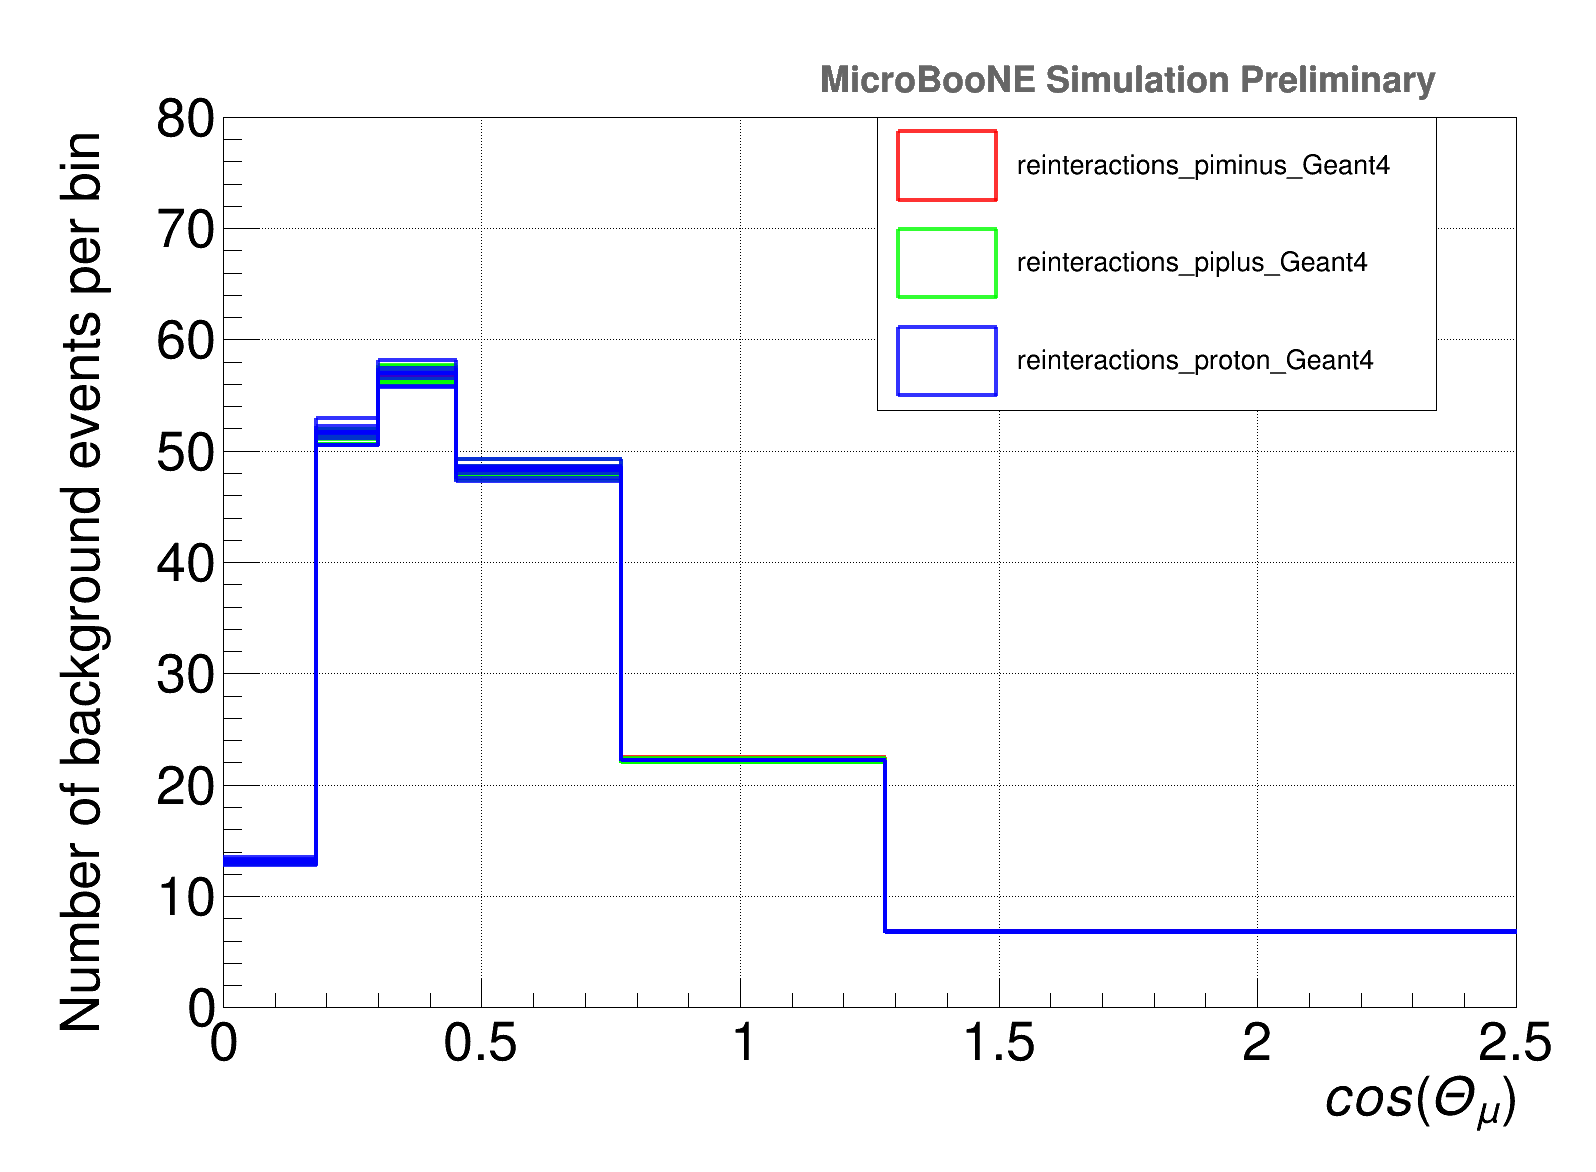

In [23]:
#legend.AddEntry(h_cv,'CV',"f")
#h_cv.SetLineWidth(3)
legend = ROOT.TLegend(0.55,0.65,0.9,0.9); #LEGEND RIGHT
h_1d_bkg[0][0].SetYTitle("Number of background events per bin")
h_1d_bkg[0][0].SetXTitle("cos(\Theta_{\mu})")
h_1d_bkg[0][0].GetYaxis().SetTitleSize(0.05)
h_1d_bkg[0][0].GetYaxis().SetTitleOffset(0.0)
h_1d_bkg[0][0].GetYaxis().SetLabelSize(0.05)
h_1d_bkg[0][0].GetXaxis().SetTitleSize(0.05)
h_1d_bkg[0][0].GetXaxis().SetLabelSize(0.05)
h_1d_bkg[0][0].GetXaxis().SetTitleOffset(1)
h_1d_bkg[0][0].SetLineColor(ROOT.kBlack)
h_1d_bkg[0][0].SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
h_1d_bkg[0][0].Draw('HIST')
for para in range(num_para):
    legend.AddEntry(h_1d_bkg[para][uni],weight_list_flux[para],"f")
    for uni in range(num_universes):      
        h_1d_bkg[para][uni].SetLineColorAlpha(para+2,0.8)
        h_1d_bkg[para][uni].SetLineWidth(4)
        h_1d_bkg[para][uni].SetMaximum(80)
        h_1d_bkg[para][uni].SetMinimum(0)
    
        h_1d_bkg[para][uni].Draw('HIST same ')
        #h_1d_xsec[para][uni]..SetMaximum(1.6)
        #print h_1d_xsec[para][uni].GetBinContent(3),' - ', h_1d_bkg[para][uni].GetBinContent(3)
legend.Draw()
#h_cv.Draw('HIST E1 same')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_1d_bkgd_G4.png")
c1.SaveAs(outputdir_root + "h_1d_bkgd_G4.root")
c1.SaveAs(outputdir_pdf + "h_1d_bkgd_G4.pdf")


In [24]:
xsec_cov_matrix = np.zeros((binnum,binnum)) # covariance matrix
xsec_corr_matrix = np.zeros((binnum,binnum)) # correlation matrix
xsec_frac_cov_matrix = np.zeros((binnum,binnum)) # fractional covariance matrix

for para in range(num_para):#num_para
    for uni in range(1):    #num_universes 
        xsec_diff_matrix = np.zeros((binnum))
        xsec_diff_matrix_1 = np.zeros((binnum))
        for i in range(1,binnum+1):
            xsec_var = h_1d_xsec[para][uni].GetBinContent(i)
            xsec_cv = h_cv.GetBinContent(i)
            xsec_diff_matrix[i-1] = xsec_var - xsec_cv
            xsec_diff_matrix_1[i-1] = (xsec_var - xsec_cv)/(xsec_cv+1e-80)
        xsec_cov_matrix = xsec_cov_matrix + xsec_diff_matrix.reshape(binnum,1) * xsec_diff_matrix
        xsec_frac_cov_matrix = xsec_frac_cov_matrix + xsec_diff_matrix_1.reshape(binnum,1) * xsec_diff_matrix_1
for i in range(binnum):
    for j in range(binnum):
        xsec_corr_matrix[i][j] = xsec_cov_matrix[i][j]/(math.sqrt(xsec_cov_matrix[i][i]*xsec_cov_matrix[j][j]))
    

In [25]:
RootFile = ROOT.TFile(output_filedir+"G4_systematic_combine.root","RECREATE");
print output_filedir

/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/


657

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/png/h_covariance_genie_other.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/root/h_covariance_genie_other.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/pdf/h_covariance_genie_other.pdf has been created


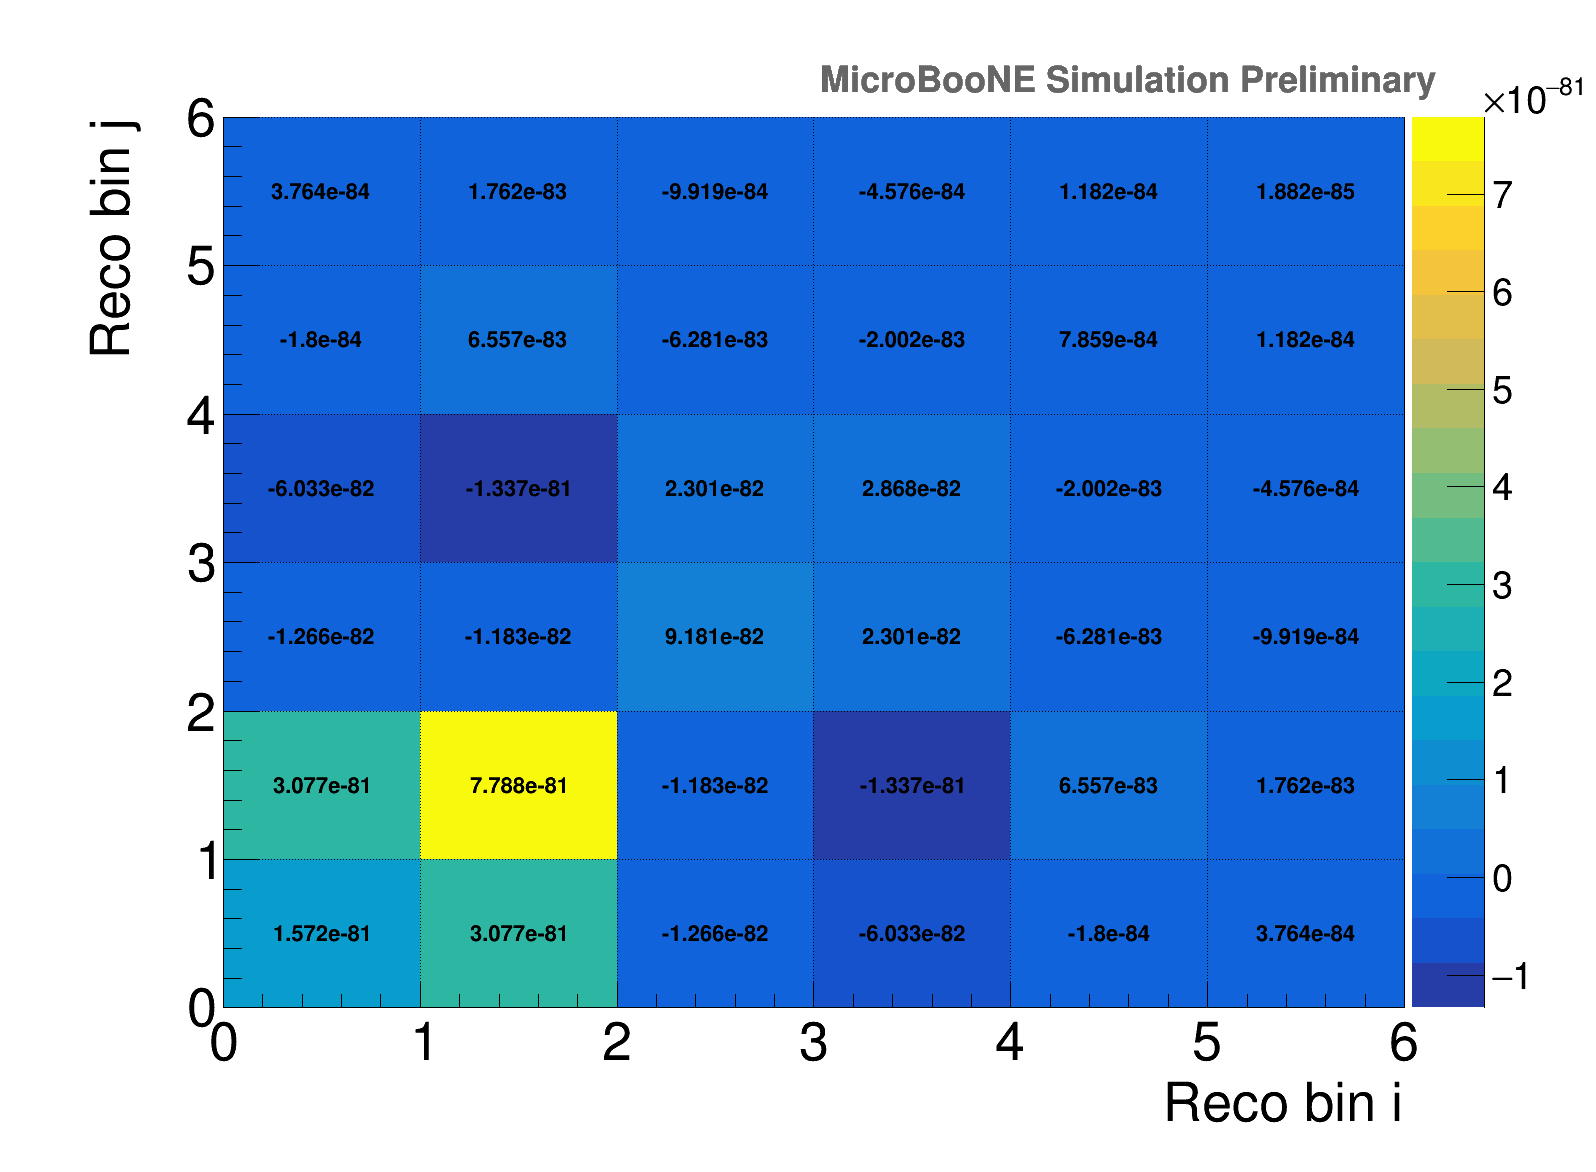

In [26]:
ROOT.gStyle.SetPaintTextFormat('0.3g')
h_covariance = ROOT.TH2D("h_covariance",'Covariance matrix',6,0,6,6,0,6)
for i in range(binnum):
    for j in range(binnum):
        h_covariance.SetBinContent(i+1,j+1,xsec_cov_matrix[i,j])
#h_covariance.SetMinimum(-1)
h_covariance.SetXTitle("Reco bin i")
h_covariance.SetYTitle("Reco bin j")
h_covariance.GetYaxis().SetTitleSize(0.05)
h_covariance.GetYaxis().SetTitleOffset(0.0)
h_covariance.GetYaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleSize(0.05)
h_covariance.GetXaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleOffset(1)
h_covariance.SetLineColor(ROOT.kBlack)
h_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.12)
ROOT.gStyle.SetPaintTextFormat('0.4g')
h_covariance.Draw('colz')
h_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_covariance_genie_other.png")
c1.SaveAs(outputdir_root + "h_covariance_genie_other.root")
c1.SaveAs(outputdir_pdf + "h_covariance_genie_other.pdf")
h_covariance.Write('h_covariance')

713

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/png/h_frac_covariance_genie_other.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/root/h_frac_covariance_genie_other.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/pdf/h_frac_covariance_genie_other.pdf has been created


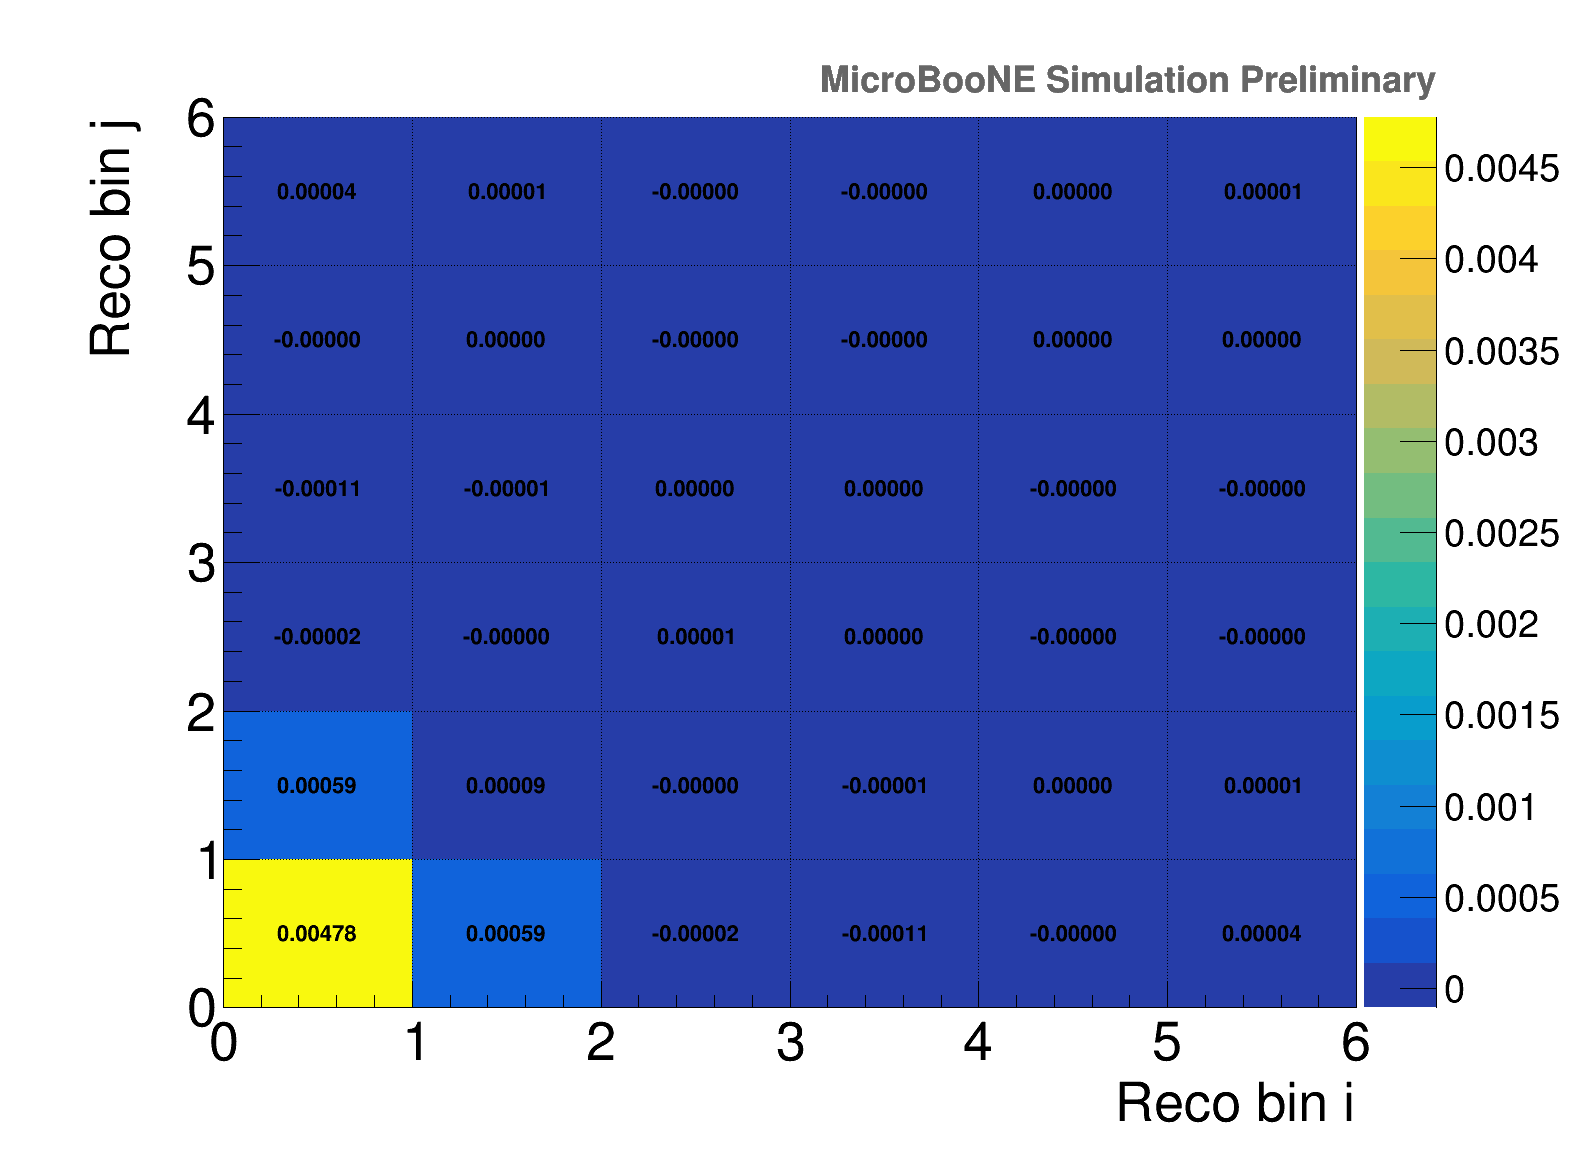

In [27]:
ROOT.gStyle.SetPaintTextFormat('0.5f')
h_frac_covariance = ROOT.TH2D("h_frac_covariance",'Fractional covariance matrix',6,0,6,6,0,6)
for i in range(binnum):
    for j in range(binnum):
        h_covariance.SetBinContent(i+1,j+1,xsec_frac_cov_matrix[i,j])
#h_covariance.SetMinimum(-1)
h_covariance.SetXTitle("Reco bin i")
h_covariance.SetYTitle("Reco bin j")
h_covariance.GetYaxis().SetTitleSize(0.05)
h_covariance.GetYaxis().SetTitleOffset(0.0)
h_covariance.GetYaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleSize(0.05)
h_covariance.GetXaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleOffset(1)
h_covariance.SetLineColor(ROOT.kBlack)
h_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.15)
ROOT.gStyle.SetPaintTextFormat('0.5f')
h_covariance.Draw('colz')
h_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_frac_covariance_genie_other.png")
c1.SaveAs(outputdir_root + "h_frac_covariance_genie_other.root")
c1.SaveAs(outputdir_pdf + "h_frac_covariance_genie_other.pdf")
h_covariance.Write('h_frac_covariance')

680

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/png/h_correlation_genie_other.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/root/h_correlation_genie_other.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/pdf/h_correlation_genie_other.pdf has been created


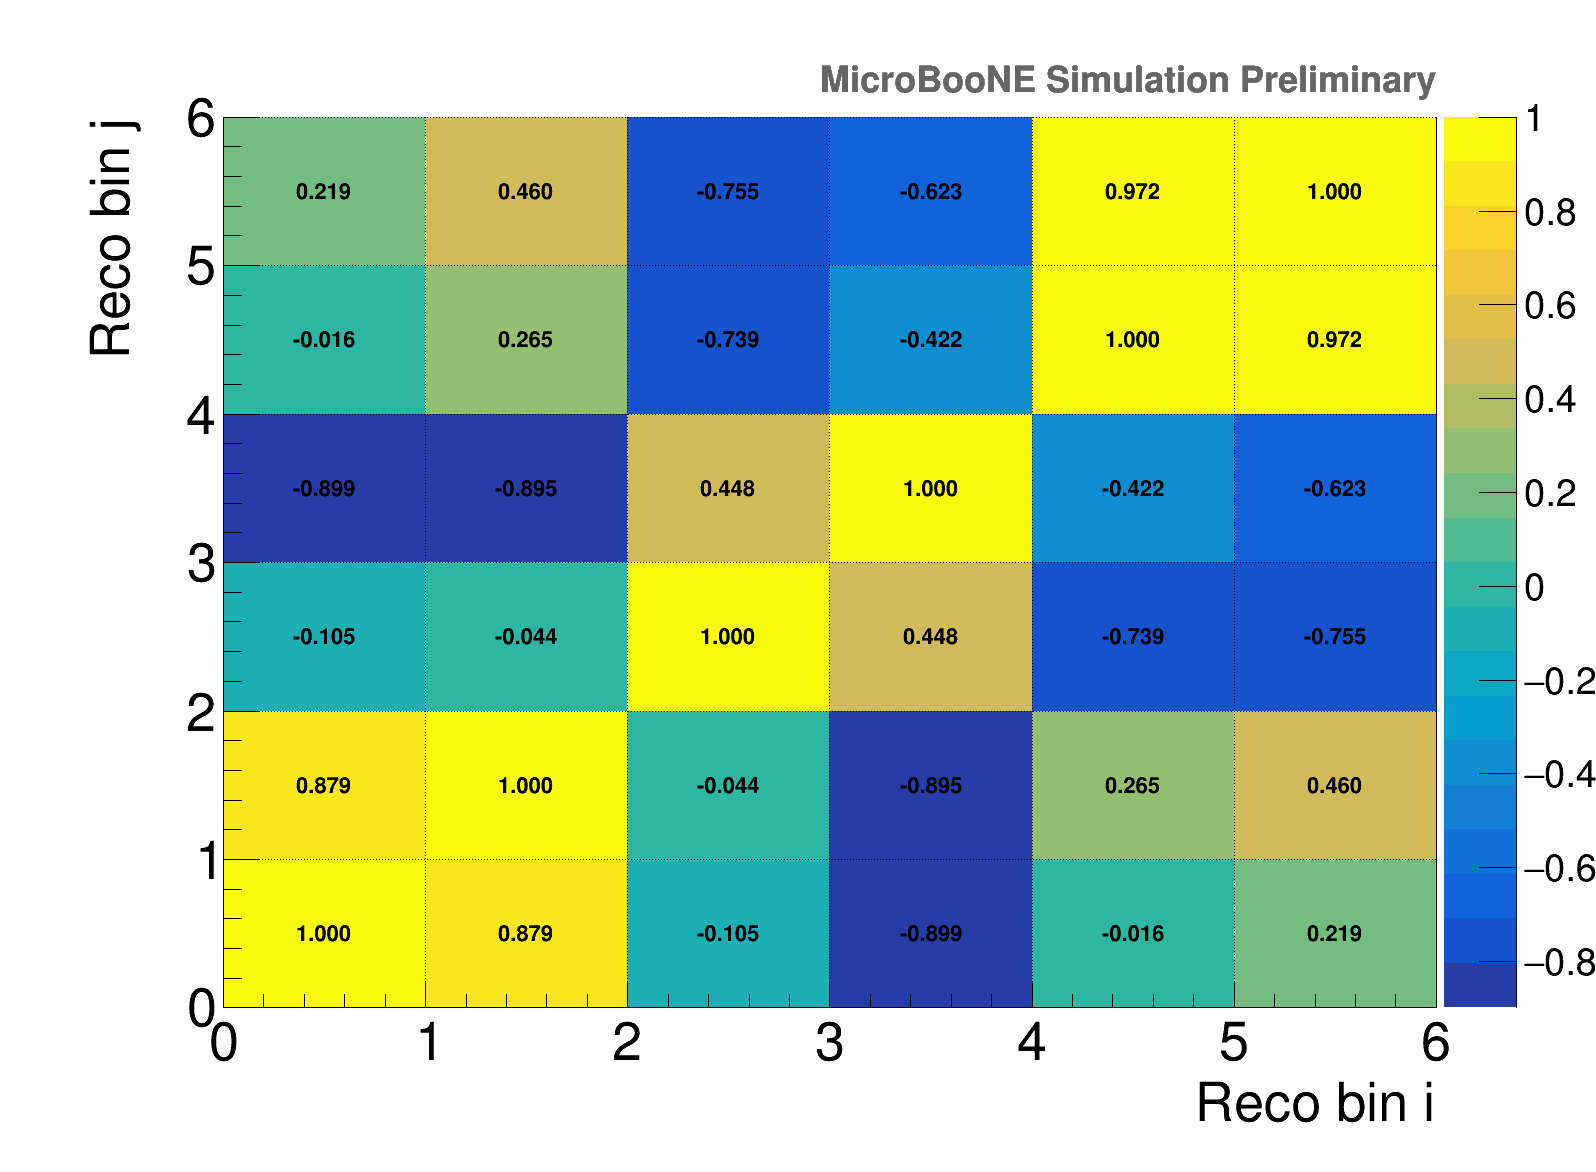

In [28]:
ROOT.gStyle.SetPaintTextFormat('0.3f')
h_correlation = ROOT.TH2D("h_correlation",'Correlation matrix',6,0,6,6,0,6)
for i in range(binnum):
    for j in range(binnum):
        h_correlation.SetBinContent(i+1,j+1,xsec_corr_matrix[i,j])
#h_correlation.SetMinimum(-1)
h_correlation.SetXTitle("Reco bin i")
h_correlation.SetYTitle("Reco bin j")
h_correlation.GetYaxis().SetTitleSize(0.05)
h_correlation.GetYaxis().SetTitleOffset(0.0)
h_correlation.GetYaxis().SetLabelSize(0.05)
h_correlation.GetXaxis().SetTitleSize(0.05)
h_correlation.GetXaxis().SetLabelSize(0.05)
h_correlation.GetXaxis().SetTitleOffset(1)
h_correlation.SetLineColor(ROOT.kBlack)
h_correlation.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
ROOT.gStyle.SetPaintTextFormat('0.3f')
h_correlation.Draw('colz')
h_correlation.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_correlation_genie_other.png")
c1.SaveAs(outputdir_root + "h_correlation_genie_other.root")
c1.SaveAs(outputdir_pdf + "h_correlation_genie_other.pdf")
h_correlation.Write('h_correlation')

In [29]:
for para in range(num_para):
    for uni in range(num_universes):   
        h_1d_xsec[para][uni].Scale(1e38)
h_cv.Scale(1e38)

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/png/h_1d_xsec_G4_stat.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/root/h_1d_xsec_G4_stat.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/pdf/h_1d_xsec_G4_stat.pdf has been created


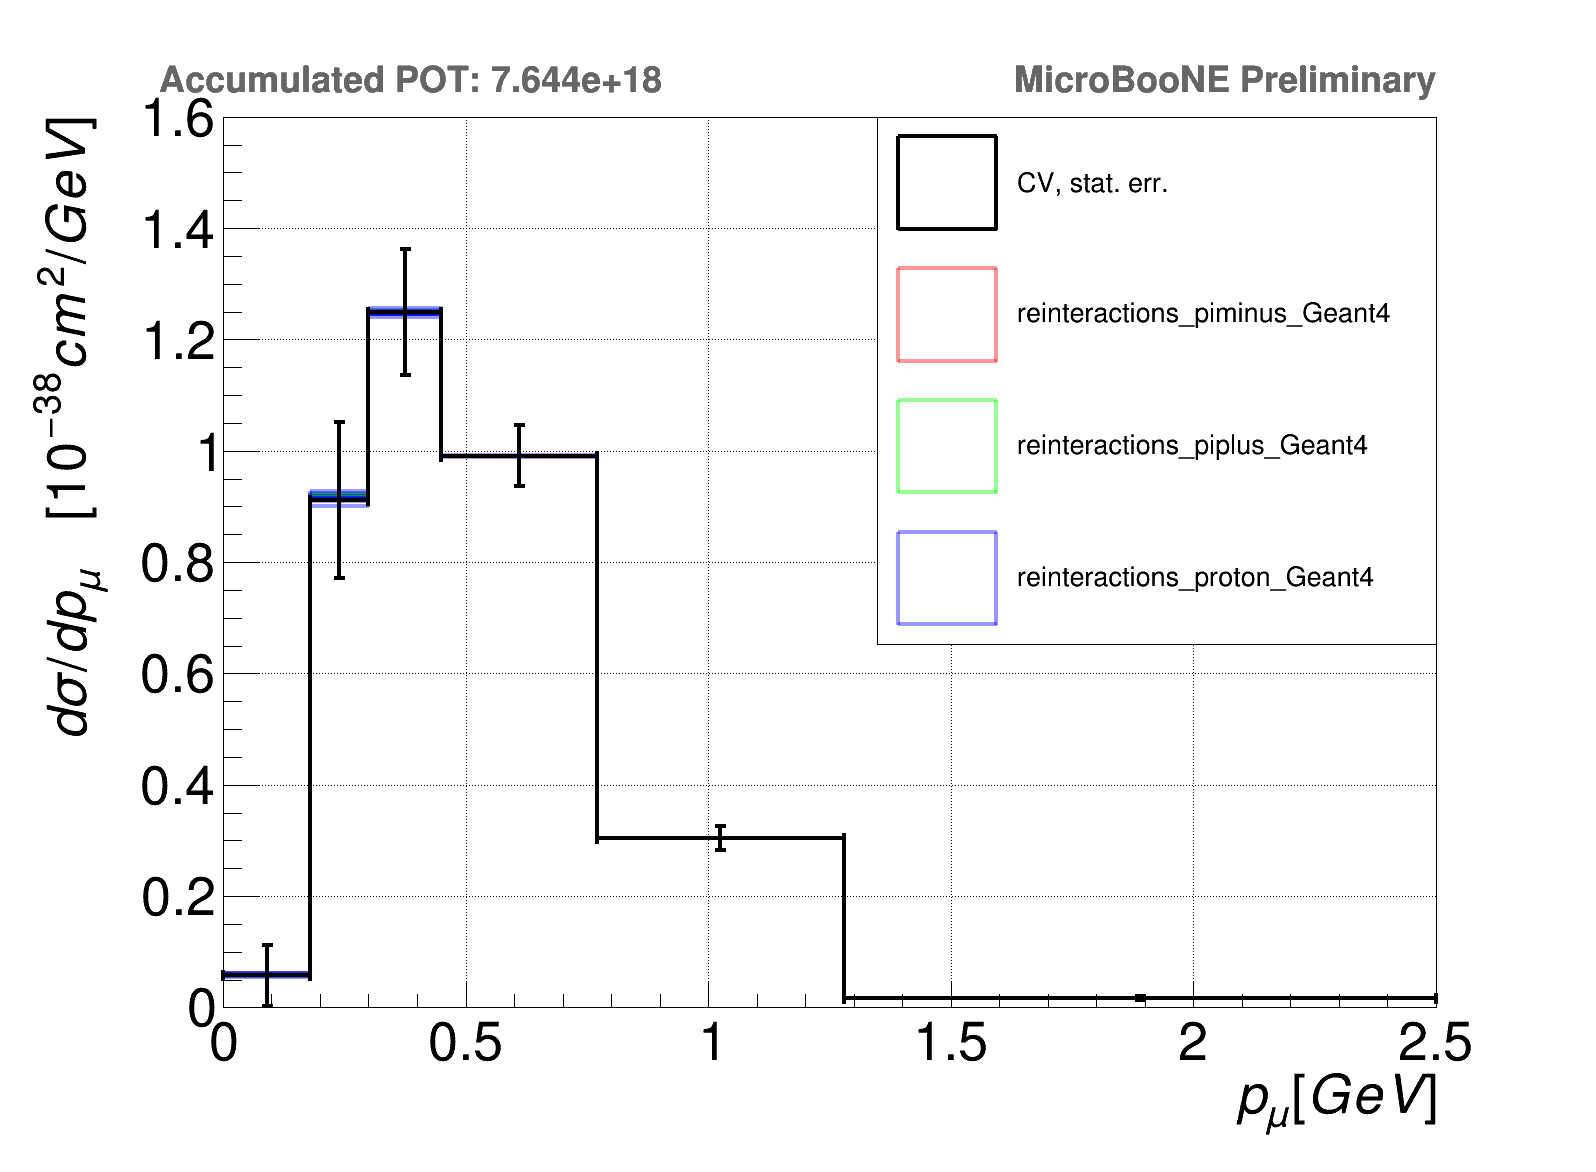

In [30]:
#stat error
h_cv.SetLineWidth(3)
h_cv.SetMaximum(1.6)
h_cv.SetYTitle("d\sigma / d p_{\mu} \t [10^{-38} cm^{2}/GeV]")
h_cv.SetXTitle("p_{\mu} [GeV]")
h_cv.GetYaxis().SetTitleSize(0.05)
h_cv.GetYaxis().SetTitleOffset(0.0)
h_cv.GetYaxis().SetLabelSize(0.05)
h_cv.GetXaxis().SetTitleSize(0.05)
h_cv.GetXaxis().SetLabelSize(0.05)
h_cv.GetXaxis().SetTitleOffset(1)
c1.SetRightMargin(0.1)
#h_covariance.SetLineColor(ROOT.kBlack)
h_cv.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
h_cv.Draw('HIST')
legend = ROOT.TLegend(0.55,0.45,0.9,0.9); #LEGEND RIGHT
legend.AddEntry(h_cv,'CV, stat. err.',"f")
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
for para in range(num_para):
    for uni in range(num_universes):        
        h_1d_xsec[para][uni].Draw('HIST same ')
        h_1d_xsec[para][uni].SetMaximum(1.6)
        h_1d_xsec[para][uni].GetYaxis().SetTitleSize(0.05)
        h_1d_xsec[para][uni].GetYaxis().SetTitleOffset(0.0)
        h_1d_xsec[para][uni].GetYaxis().SetLabelSize(0.05)
        h_1d_xsec[para][uni].GetXaxis().SetTitleSize(0.05)
        h_1d_xsec[para][uni].GetXaxis().SetLabelSize(0.05)
        h_1d_xsec[para][uni].GetXaxis().SetTitleOffset(1)
        h_1d_xsec[para][uni].SetLineColorAlpha(para+2,0.4)
        #h_1d_xsec[para][uni].SetLineWidth(4)
        c1.SetRightMargin(0.1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_1d_xsec[para][uni].SetLineWidth(4)
        ROOT.gStyle.SetEndErrorSize(5)
        #print h_1d_xsec[para][uni].GetBinContent(3),' - ', h_1d_bkg[para][uni].GetBinContent(3)
    legend.AddEntry(h_1d_xsec[para][uni],weight_list_flux[para],"f")
legend.Draw()
h_cv.Draw('HIST E1 same')
h_stat = h_cv.Clone()
c1.Draw()
c1.SaveAs(outputdir_png + "h_1d_xsec_G4_stat.png")
c1.SaveAs(outputdir_root + "h_1d_xsec_G4_stat.root")
c1.SaveAs(outputdir_pdf + "h_1d_xsec_G4_stat.pdf")


0.0573576688766 0.00396439330372
0.911590874195 0.00882496122936
1.24903178215 0.00303005107722
0.991361796856 0.00169343715587
0.303822100163 0.000280338785003
0.0176406670362 4.338461686e-05


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/png/h_1d_xsec_G4_sys.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/root/h_1d_xsec_G4_sys.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/pdf/h_1d_xsec_G4_sys.pdf has been created


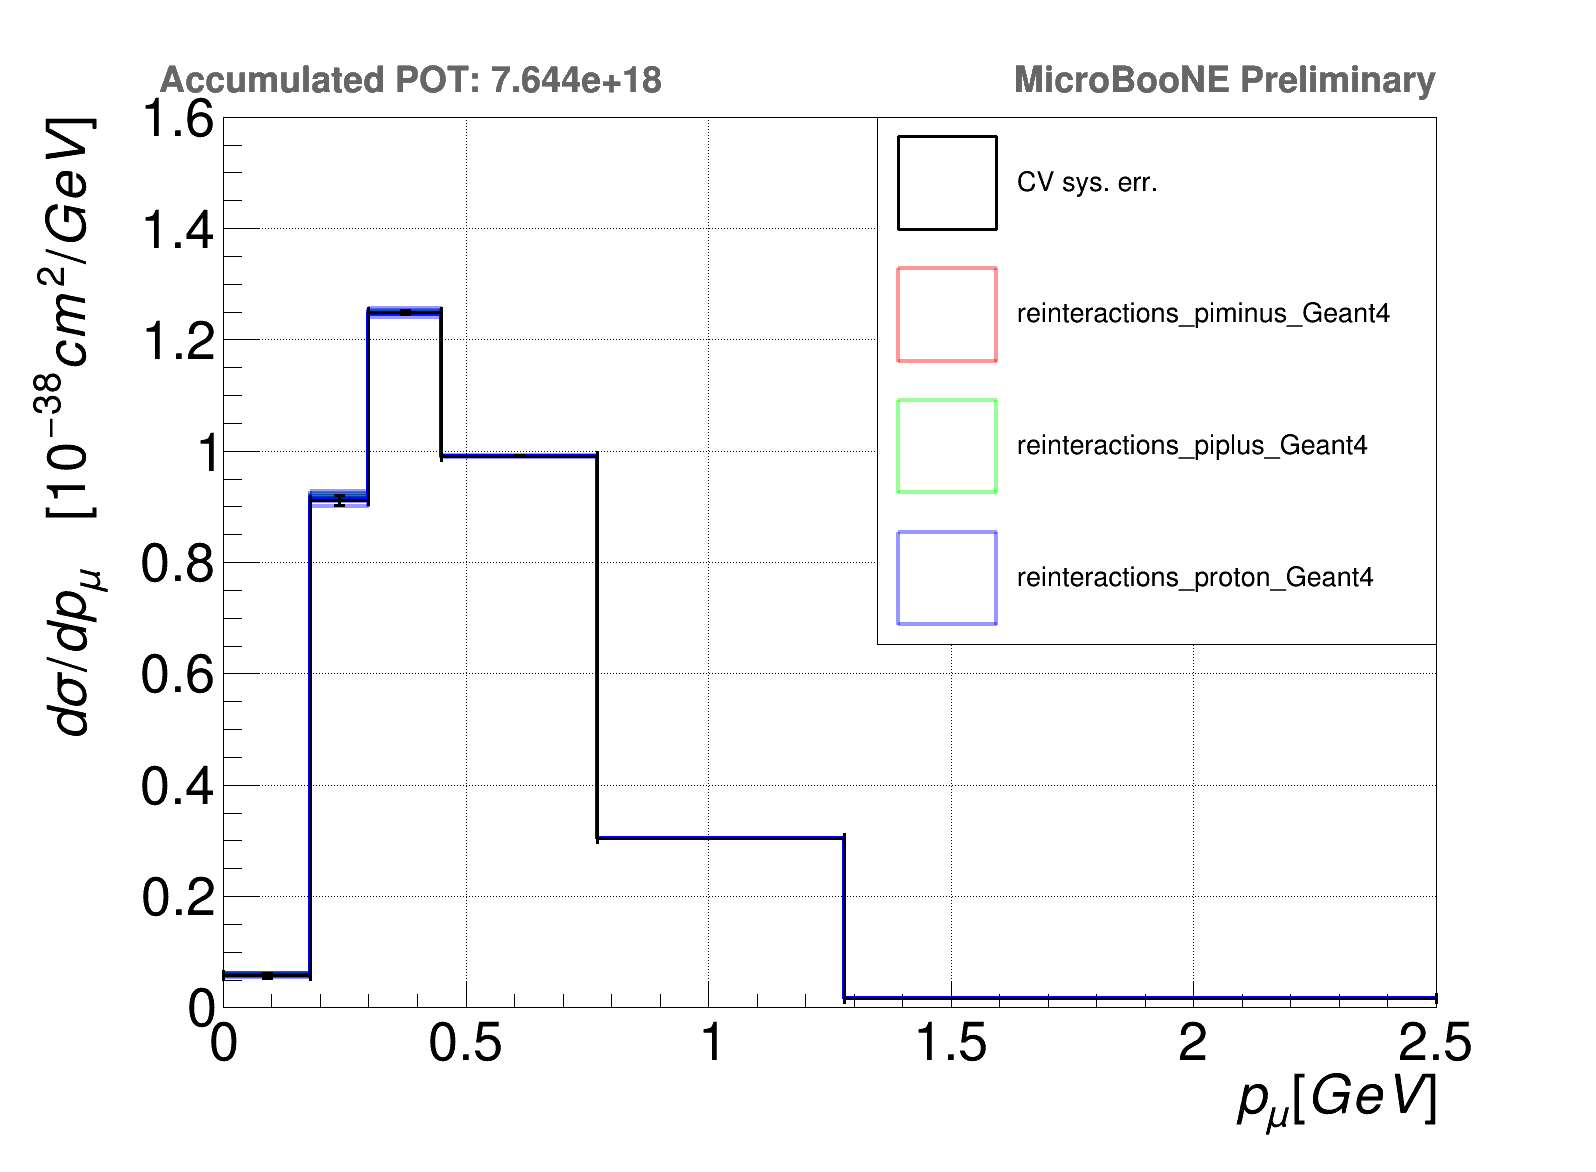

In [31]:
# only ststematic error
h_cv.SetLineWidth(3)
h_cv.SetMaximum(1.6)
h_cv.SetYTitle("d\sigma / d p_{\mu} \t [10^{-38} cm^{2}/GeV]")
h_cv.SetXTitle("p_{\mu} [GeV]")
h_cv.Draw('HIST')
legend = ROOT.TLegend(0.55,0.45,0.9,0.9); #LEGEND RIGHT
legend.AddEntry(h_cv,'CV sys. err.',"f")
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
for para in range(num_para):
    for uni in range(num_universes):        
        h_1d_xsec[para][uni].Draw('HIST same ')
        h_1d_xsec[para][uni].SetMaximum(1.6)
        #print h_1d_xsec[para][uni].GetBinContent(3),' - ', h_1d_bkg[para][uni].GetBinContent(3)
    legend.AddEntry(h_1d_xsec[para][uni],weight_list_flux[para],"f")
legend.Draw()
for i in range(binnum):
    h_cv.SetBinError(i+1,math.sqrt(xsec_cov_matrix[i][i])*1e38)
    print h_cv.GetBinContent(i+1), h_cv.GetBinError(i+1)
h_cv.Draw('HIST E1 same')
c1.Draw()
c1.SaveAs(outputdir_png + "h_1d_xsec_G4_sys.png")
c1.SaveAs(outputdir_root + "h_1d_xsec_G4_sys.root")
c1.SaveAs(outputdir_pdf + "h_1d_xsec_G4_sys.pdf")


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/png/h_xsec_G4_tot_error.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/root/h_xsec_G4_tot_error.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/pdf/h_xsec_G4_tot_error.pdf has been created


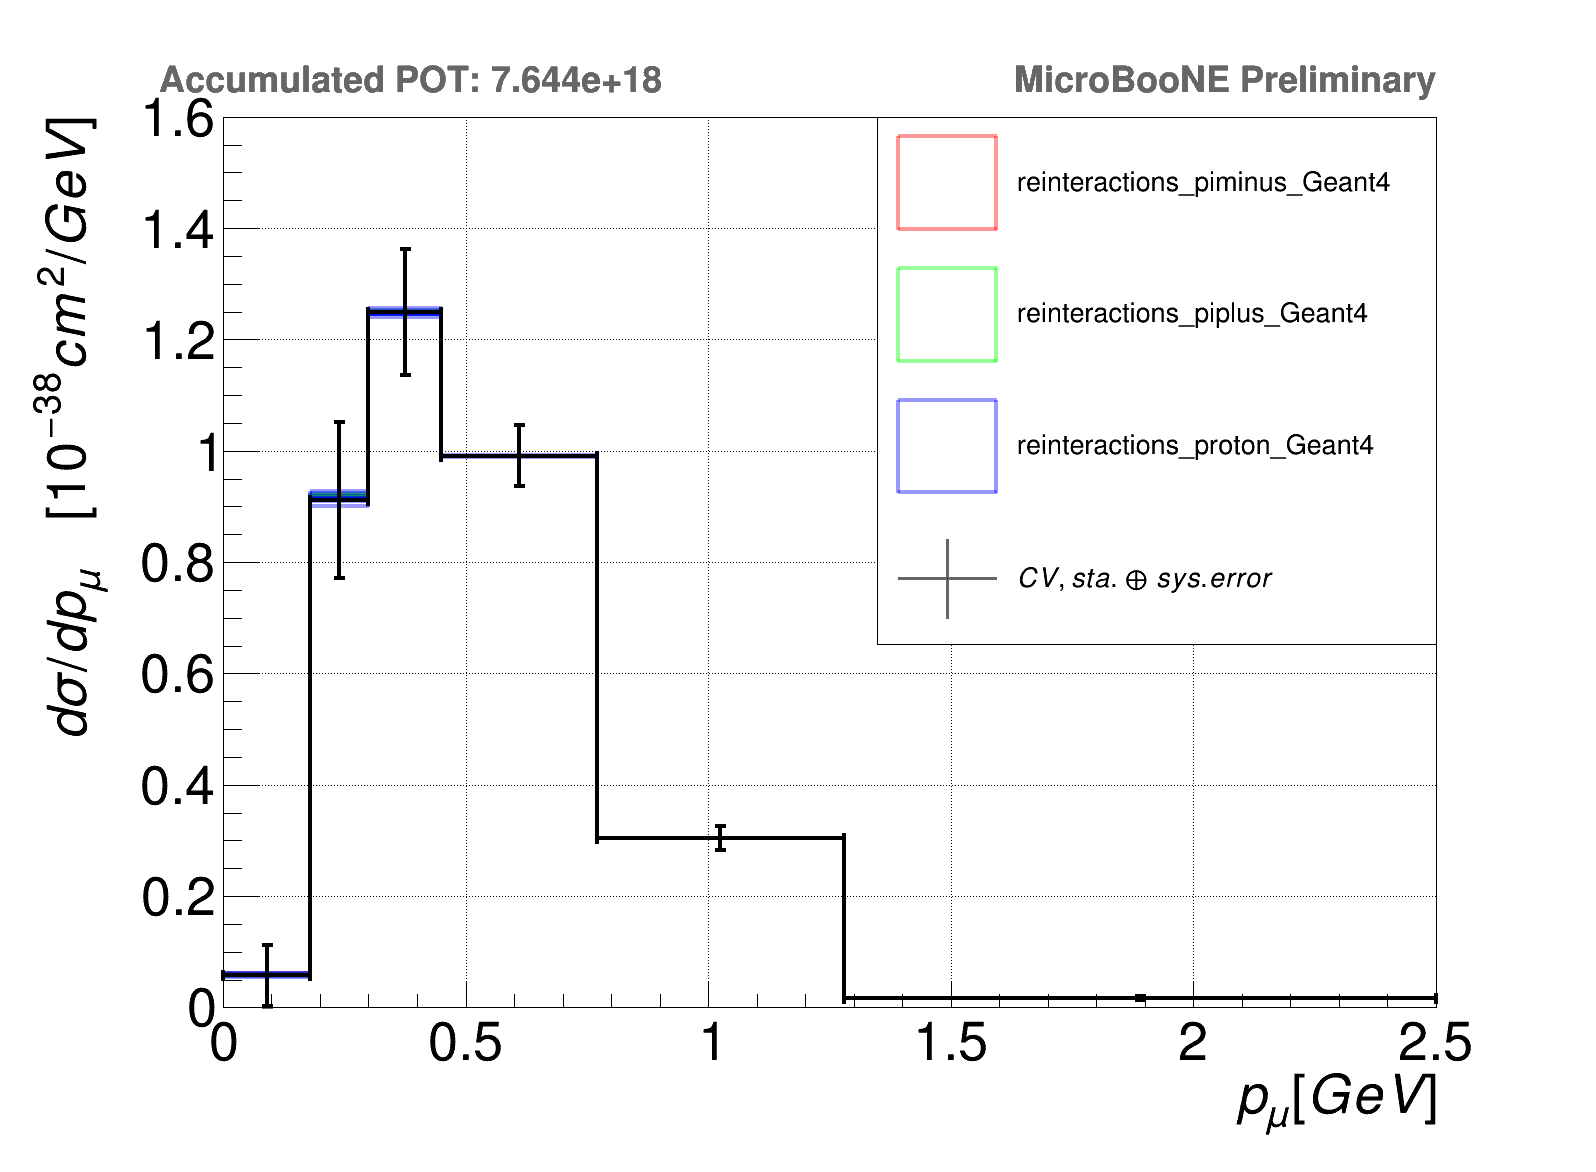

In [32]:
#with sys error
legend = ROOT.TLegend(0.55,0.45,0.9,0.9); #LEGEND RIGHT
#legend = ROOT.TLegend(0.15,0.55,0.3,0.9); #LEGEND LEFT
h_cv.Draw('hist')
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
for para in range(num_para):
    for uni in range(num_universes):
        h_1d_xsec[para][uni].SetMaximum(1.6)
        #h_1d_xsec[para][uni].SetLineColorAlpha(ROOT.kRed,0.6)
        h_1d_xsec[para][uni].SetYTitle("d\sigma / d p_{\mu} \t [10^{-38} cm^{2}/GeV]")
        h_1d_xsec[para][uni].SetXTitle("p_{\mu} [GeV]")
        h_1d_xsec[para][uni].Draw('hist same')
    legend.AddEntry(h_1d_xsec[para][uni],weight_list_flux[para],"f")
for i in range(binnum):
    h_cv.SetBinError(i,math.sqrt(xsec_cov_matrix[i][i]*1e76+math.pow(h_stat.GetBinError(i),2)))
h_cv.SetLineColor(ROOT.kGray+2)
#legend.AddEntry(h_xsec[0],'All Genie                 ',"f")
legend.AddEntry(h_cv,'CV, sta. \oplus sys. error',"lep")
#legend.AddEntry(h_stat,'CV, stat. error',"lep")
legend.Draw()
h_cv.Draw('hist E1 same') 
h_stat.SetLineColor(ROOT.kBlack)
h_stat.Draw('hist E1 same')
c1.Draw()
c1.SaveAs(outputdir_png + "h_xsec_G4_tot_error.png")
c1.SaveAs(outputdir_root + "h_xsec_G4_tot_error.root")
c1.SaveAs(outputdir_pdf + "h_xsec_G4_tot_error.pdf")

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/png/h_eff_tilde_G4.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/root/h_eff_tilde_G4.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/pdf/h_eff_tilde_G4r.pdf has been created


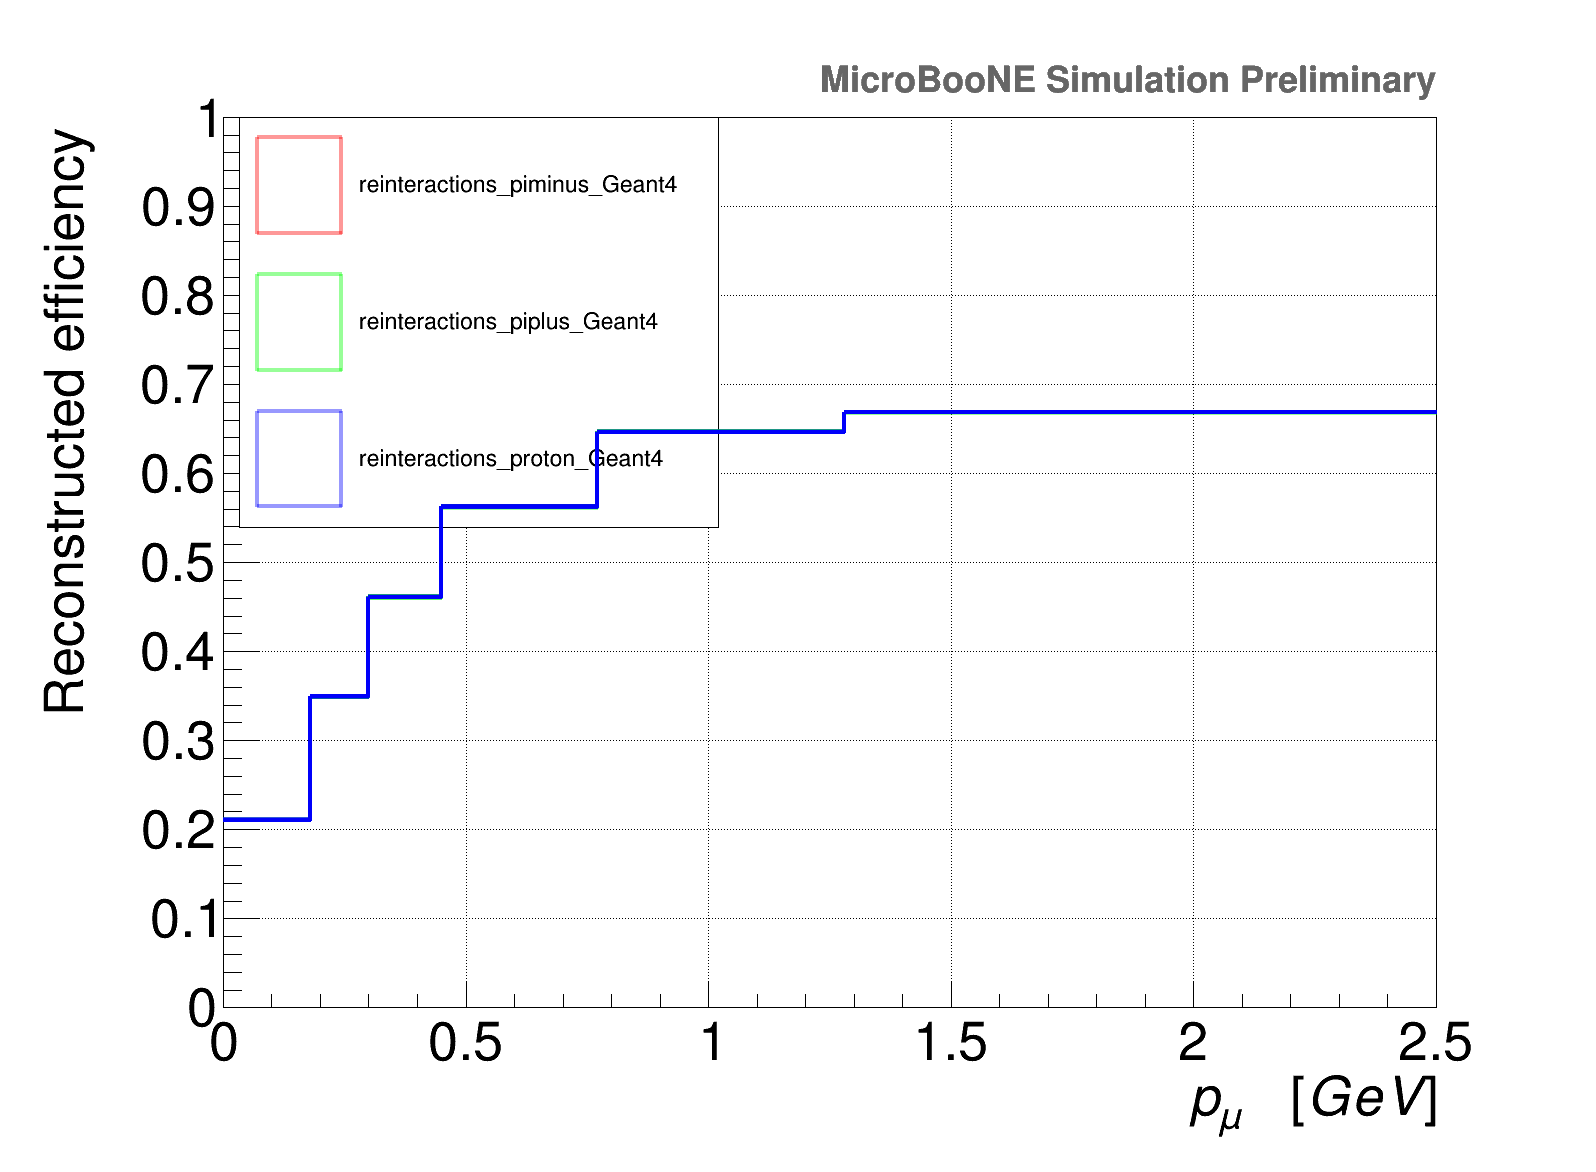

In [33]:
legend = ROOT.TLegend(0.15,0.55,0.45,0.9); #LEGEND LEFT
for para in range(num_para):
    for uni in range(num_universes):        
        h_eff_tilde[para][uni].SetMaximum(1)
        h_eff_tilde[para][uni].SetMinimum(0)
        h_eff_tilde[para][uni].SetLineColorAlpha(para+2,0.4)
        h_eff_tilde[para][uni].SetLineWidth(3)
        h_eff_tilde[para][uni].SetYTitle("Reconstructed efficiency")
        h_eff_tilde[para][uni].SetXTitle("p_{\mu} \t [GeV]")
        h_eff_tilde[para][uni].GetYaxis().SetTitleSize(0.05)
        h_eff_tilde[para][uni].GetYaxis().SetTitleOffset(0.0)
        h_eff_tilde[para][uni].GetYaxis().SetLabelSize(0.05)
        h_eff_tilde[para][uni].GetXaxis().SetTitleSize(0.05)
        h_eff_tilde[para][uni].GetXaxis().SetLabelSize(0.05)
        h_eff_tilde[para][uni].GetXaxis().SetTitleOffset(1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_eff_tilde[para][uni].SetLineWidth(4)
        ROOT.gStyle.SetEndErrorSize(5)
        if(para == 0 and uni==0):
            
            h_eff_tilde[para][uni].Draw('HIST')
            legend.Draw()
        else:
            h_eff_tilde[para][uni].Draw('HIST same ')

    legend.AddEntry(h_eff_tilde[para][uni],weight_list_flux[para],"f")
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_tilde_G4.png")
c1.SaveAs(outputdir_root + "h_eff_tilde_G4.root")
c1.SaveAs(outputdir_pdf + "h_eff_tilde_G4r.pdf")


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/png/h_eff_true_G4.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/root/h_eff_true_G4.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/pdf/h_eff_true_G4.pdf has been created


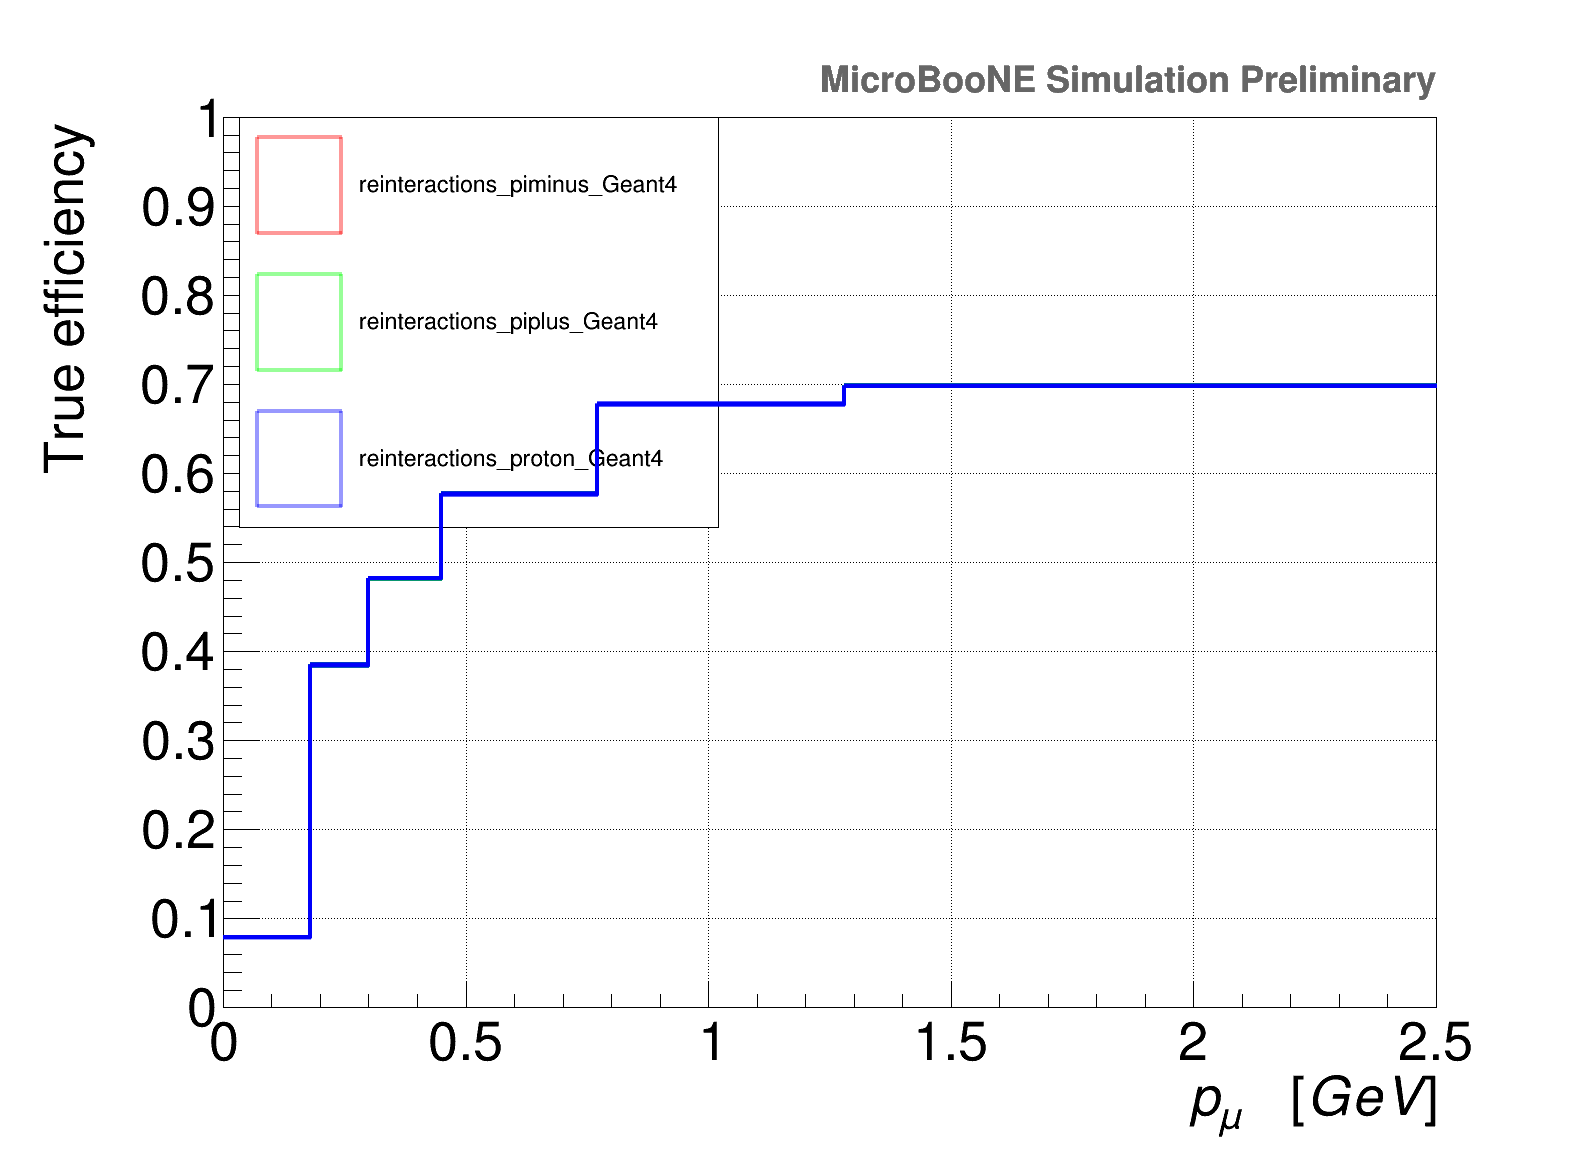

In [34]:
legend = ROOT.TLegend(0.15,0.55,0.45,0.9); #LEGEND LEFT
for para in range(num_para):
    for uni in range(num_universes):        
        h_eff_true[para][uni].SetMaximum(1)
        h_eff_true[para][uni].SetMinimum(0)
        h_eff_true[para][uni].SetLineColorAlpha(para+2,0.4)
        h_eff_true[para][uni].SetLineWidth(3)
        h_eff_true[para][uni].SetYTitle("True efficiency")
        h_eff_true[para][uni].SetXTitle("p_{\mu} \t [GeV]")
        h_eff_true[para][uni].GetYaxis().SetTitleSize(0.05)
        h_eff_true[para][uni].GetYaxis().SetTitleOffset(0.0)
        h_eff_true[para][uni].GetYaxis().SetLabelSize(0.05)
        h_eff_true[para][uni].GetXaxis().SetTitleSize(0.05)
        h_eff_true[para][uni].GetXaxis().SetLabelSize(0.05)
        h_eff_true[para][uni].GetXaxis().SetTitleOffset(1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_eff_true[para][uni].SetLineWidth(4)
        #ROOT.gStyle.SetEndErrorSize(5)
        if(para == 0 and uni==0):
            h_eff_true[para][uni].Draw('HIST')
            legend.Draw()
        else:
            h_eff_true[para][uni].Draw('HIST same ')

    legend.AddEntry(h_eff_true[para][uni],weight_list_flux[para],"f")
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_true_G4.png")
c1.SaveAs(outputdir_root + "h_eff_true_G4.root")
c1.SaveAs(outputdir_pdf + "h_eff_true_G4.pdf")


In [35]:
# close the root file with all the histos
RootFile.Close()